In [1]:
# last step: save the exp object to a pkl file
import pickle
import sys 
sys.path.append('codes')
from scipy.optimize import curve_fit
import MyFunctions as mf
import matplotlib.pyplot as plt
import rixs_tools as rt
from scipy.signal import convolve
import numpy as np
from rixs_experiment import RIXS_EXP 
#System = rt.create_system()
_temp_exp  = RIXS_EXP()

folder = 'processed_data/'
filename = 'processed_exp.pkl'

with open(folder+filename, 'rb') as input_file:
    exp = pickle.load(input_file)

def peaks_of_chi(c,Gamma,Delta):
    def _fun_chi(y,q,c,Gamma,Delta):   
            q_cdf = 0.24
            #normalization_factor = 1/2 * 1/np.sqrt(c**2*(x-q_cdf)**2+Delta**2) # do I need this?????????????
            normalization_factor = 1
            chi = 1/(Delta**2 + c**2*(q-q_cdf)**2- (y + 1j*(Gamma))**2)
            output = np.imag(chi * normalization_factor)
            return output
    x = np.linspace(0.05,0.287,1000)
    y = np.linspace(-20,100,1000)
    X,Y = np.meshgrid(x,y)
    Z = _fun_chi(Y,X,c,Gamma,Delta)

    peak = np.zeros(np.shape(x))
    for q_index, q in enumerate(x):
        peak[q_index] = y[Z[:,q_index]==np.max(Z[:,q_index])]

    return x,peak

def bose_factor(energy,T):
    temp = 1/(np.exp(energy/T)-1)
    temp[energy>0] = temp[energy>0] + 1
    return temp


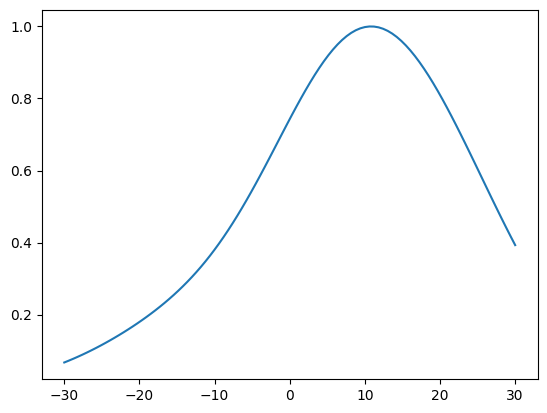

In [2]:
def chi_square(z_data,z_fitting,sigma=1):
    diff = (z_data - z_fitting)/sigma
    diff_square = diff**2
    return np.sum(diff_square)

def fun_chi(x,y,c,A,Gamma,Delta):   
        q_cdf = 0.24
        #normalization_factor = 1/2 * 1/np.sqrt(c**2*(x-q_cdf)**2+Delta**2) # do I need this?????????????
        normalization_factor = 1
        chi = 1/(Delta**2 + c**2*(x-q_cdf)**2- (y + 1j*(Gamma))**2)
        output = np.imag(chi * normalization_factor)
        return output/np.max(output)*A

def fun_S(x,y,c,A,Gamma,Delta,T):
    temp = fun_chi(x,y,c,A,Gamma,Delta)
    temp[y<0] = np.exp(y[y<0]/T)*fun_chi(x,-y[y<0],c,A,Gamma,Delta)
    return temp

def n(y,T):
    return 1/(np.exp(y/T)-1)

def fun_S_convoluted(y, q, c, A, Gamma, Delta, T):
    """
    Calculate the convoluted function of S(x, y) with a Gaussian resolution function.

    Parameters:
    x (float): Momentum (r.l.u.)
    y (array-like): Energy loss (meV)
    c (float): Slope of the dispersion
    A (float): Amplitude
    Gamma (float): Damping (meV)
    Delta (float): Energy gap (meV)
    T (float): Temperature in meV

    Returns:
    array-like: The convoluted function of S(x, y) with a Gaussian resolution function, normalized to the maximum value.

    """
    y_left = np.min(y)
    y_right = np.max(y)
    y_left_shifted = y_left - (y_right + y_left) / 2
    y_right_shifted = y_right - (y_right + y_left) / 2
    y_gaussian = np.linspace(y_left_shifted, y_right_shifted, len(y))
    res = _temp_exp._resolution
    z = fun_S(q, y, c, A, Gamma, Delta, T)
    z_conv = convolve(z, mf.fun_gaussian(y_gaussian, 0, 1, res), mode='same')
    return z_conv / max(z_conv) * A

# test fun_S 
x = 0.24
q=0.24
y = np.linspace(-30,30,100)
c = 0
A = 1
Gamma = 20
T = 15
Delta = 10
res = 22
z = mf.fun_S_convoluted_new(y, q, c, A, Gamma, Delta,T)

plt.plot(y,z)


1.8102
5.3444
8.9648
13.361


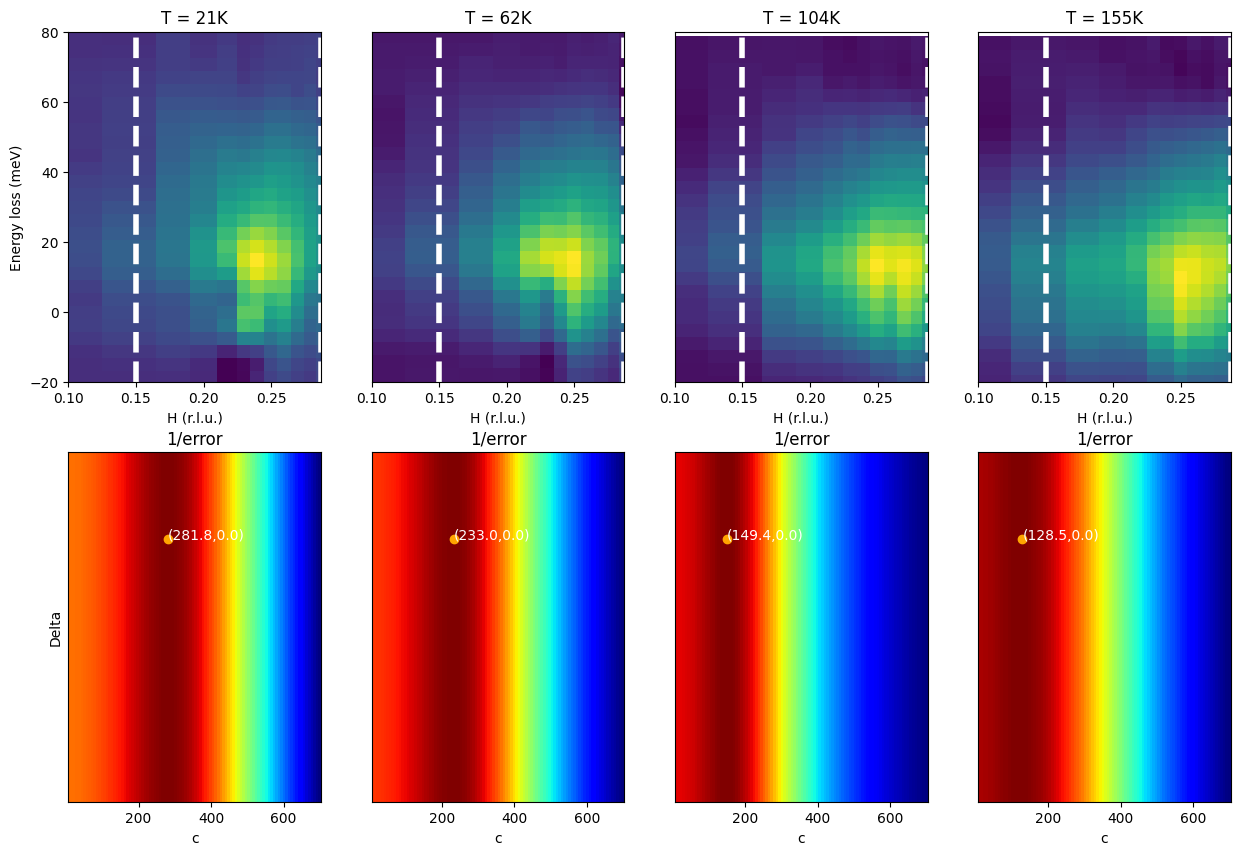

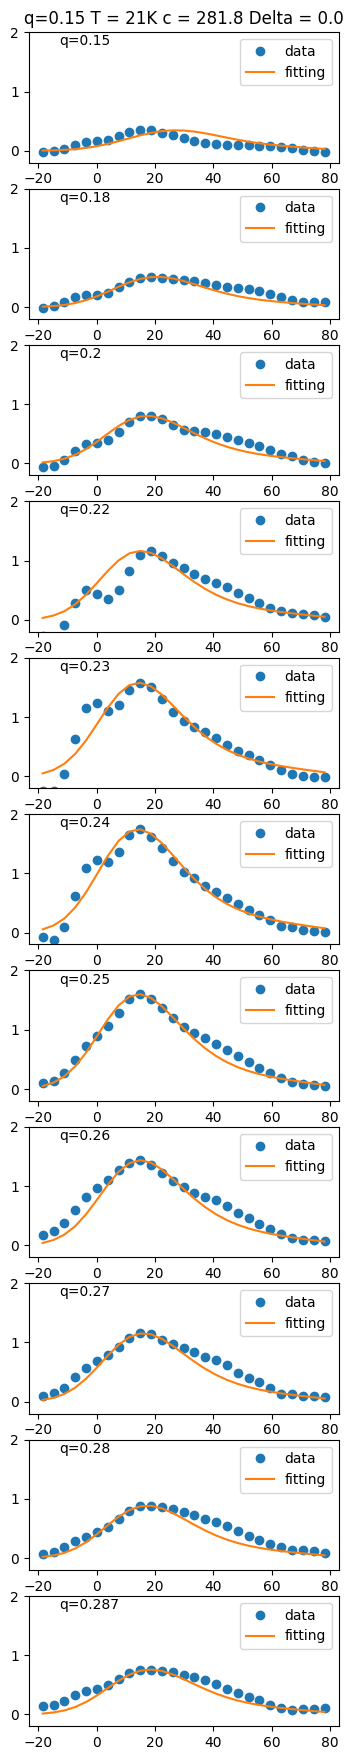

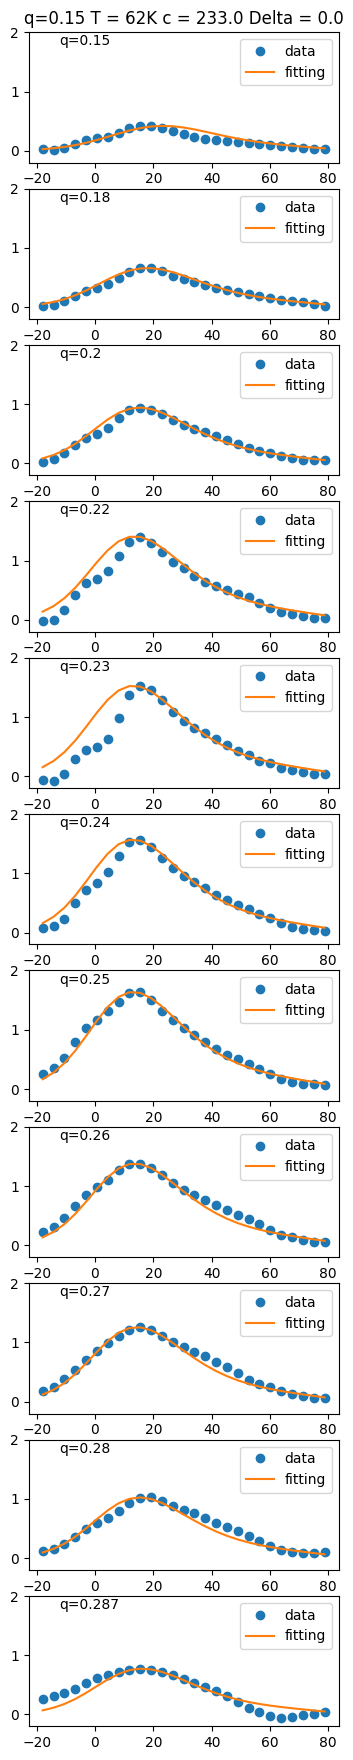

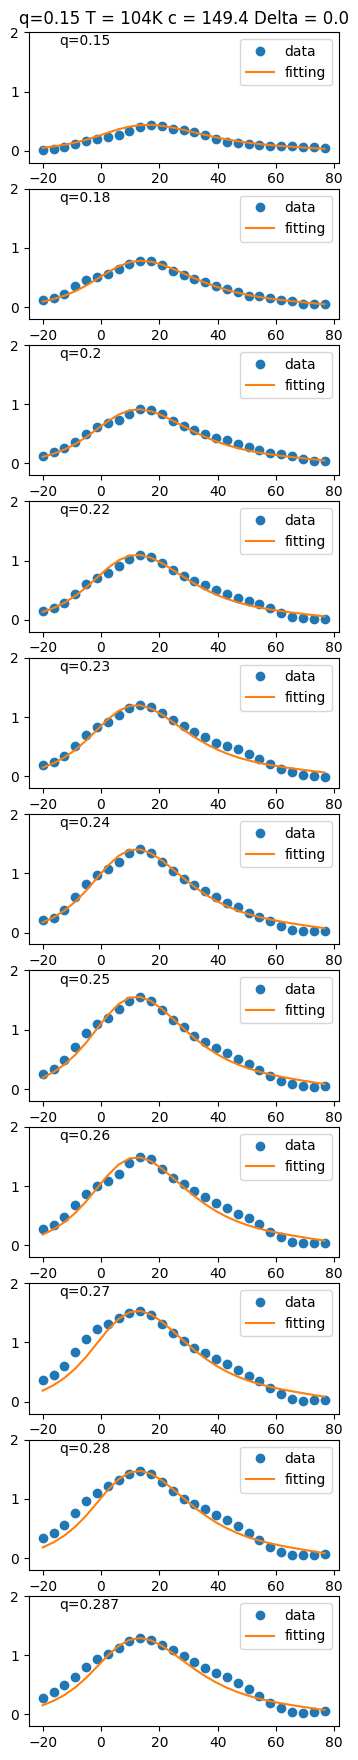

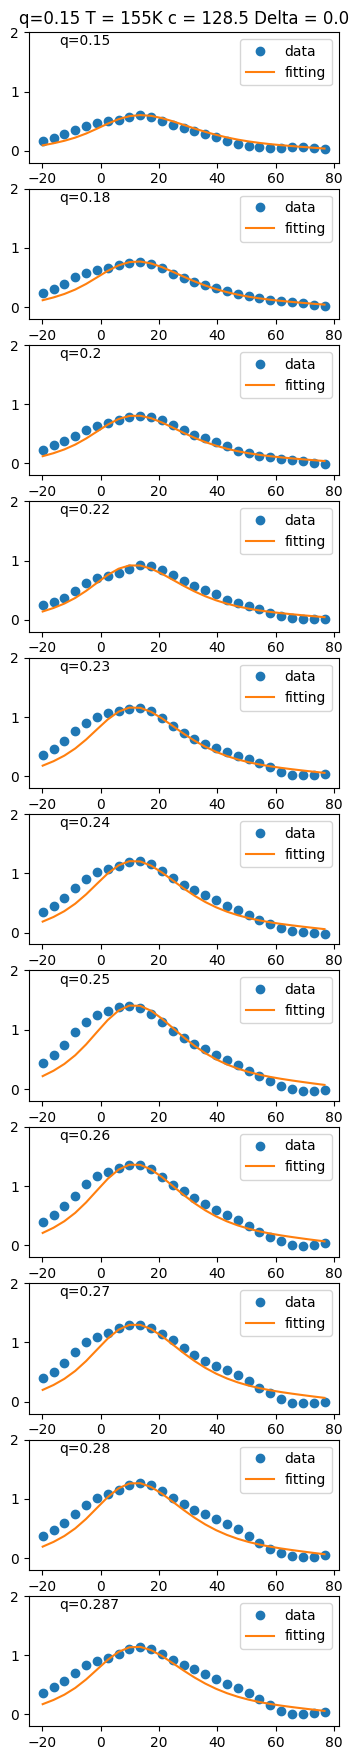

In [3]:
c_set = np.linspace(10,700,100)
Delta_set = np.linspace(0.01,0.012,2)
q_list =  exp.q_list
q_interest_list = [2,3,4,5,6,7,8,9,10,11,12]
chi_mesh = np.zeros((len(c_set),len(Delta_set)))
Gamma_set = [19,22.6,23.6,24.8]

energy_min = -20
energy_max = 80

fig4, ax4 = plt.subplots(2,4,figsize=(15,10))
c_best_list = np.zeros(4)

for temperature_index in range(4):
    Gamma = Gamma_set[temperature_index]
    temperature_char = exp._temperature_list_string[temperature_index]
    temperature = exp._temperature_list_K[temperature_index]
    temperature_meV = exp._temperature_list_meV[temperature_index]
    print(temperature_meV)
    # load data
    x= exp.Pure_CDF_data[temperature_char]['x']
    y_temp = exp.Pure_CDF_data[temperature_char]['y']
    cdf_temp = exp.Pure_CDF_data[temperature_char]['Z_subtracted']
    X,Y = np.meshgrid(x,y_temp)
    y = y_temp[(y_temp > energy_min)&(y_temp<energy_max)]
    sigma = np.ones(len(y))
    sigma[(y>10)&(y<25)]=0.3
    arg_list = np.argwhere((y_temp>energy_min)&(y_temp<energy_max))
    cdf = cdf_temp[arg_list[0][0]:arg_list[-1][0]+1,:]

    for c_index, c in enumerate(c_set):
        for Delta_index, Delta in enumerate(Delta_set):
            i_plot = 0
            sum_chi_square = 0
            for q_index, q in enumerate(q_list):
                z_data = cdf[:,q_index]
                p0 = [x[q_index],c_set[c_index],np.max(cdf[:,q_index]), Gamma, Delta_set[Delta_index], temperature_meV]
                epsilon = 0.0001
                bounds = ([x[q_index]-epsilon,c_set[c_index]-epsilon,0, Gamma-epsilon, Delta_set[Delta_index]-epsilon, temperature_meV-epsilon],\
                          [x[q_index]+epsilon,c_set[c_index]+epsilon,5, Gamma+epsilon, Delta_set[Delta_index]+epsilon, temperature_meV+epsilon])
                #popt, pcov = curve_fit(fun_S_convoluted, y, z_data, p0 = p0, bounds=bounds, sigma=sigma)
                #intensity = popt[2]
                #z_fitting = fun_S_convoluted(y,x[q_index], c_set[c_index], intensity, Gamma, Delta_set[Delta_index], temperature_meV)  
                z_fitting = mf.fun_S_convoluted_new(y,x[q_index], c_set[c_index], np.max(z_data), Gamma, Delta_set[Delta_index], temperature_meV)  
                if q_index in q_interest_list:
                    sum_chi_square = sum_chi_square + chi_square(z_data,z_fitting,sigma)
                chi_mesh[c_index,Delta_index] = np.sqrt(sum_chi_square)

    # plot the 3d surface and the pcolor plot of chi_square
    C,D = np.meshgrid(c_set,Delta_set)
    X,Y = np.meshgrid(x,y)
    ax4[0][temperature_index].pcolor(X,Y,cdf)
    ax4[0][temperature_index].set_xlim([0.1,0.287])
    ax4[0][temperature_index].set_ylim([energy_min,energy_max])
    ax4[0][temperature_index].set_xlabel('H (r.l.u.)')
    ax4[0][temperature_index].set_yticks([])
    #ax4[0][temperature_index].set_ylim([3,80])
    ax4[0][temperature_index].set_title('T = '+str(exp.temperature_list_K[temperature_index])+'K')
    ax4[0][temperature_index].axvline(x=q_list[q_interest_list[0]], color='white', linewidth=4, linestyle='--')
    ax4[0][temperature_index].axvline(x=q_list[q_interest_list[-1]], color='white', linewidth=4, linestyle='--')
    reward = 1/chi_mesh.T
    ax4[1][temperature_index].pcolor(C,D,reward,cmap='jet')
    ax4[1][temperature_index].set_xlabel('c')
    ax4[1][temperature_index].set_yticks([])
    if temperature_index == 0: 
        ax4[0][temperature_index].set_ylabel('Energy loss (meV)')
        ax4[0][temperature_index].set_yticks([energy_min,0,20,40,60,energy_max])
        ax4[1][temperature_index].set_ylabel('Delta')
        ax4[1][temperature_index].set_yticks([0,5,10,15,20])

    ax4[1][temperature_index].set_title('1/error')
    # find the highest reward, put a orange there 
    max_index = np.argwhere(reward == np.max(reward))
    ax4[1][temperature_index].scatter(C[reward==np.max(reward)],D[reward==np.max(reward)],color='orange')
    # write the c and delta coordinate as a text on the figure. keep only 1 decimal
    ax4[1][temperature_index].text(C[reward==np.max(reward)],D[reward==np.max(reward)],'('+str(round(C[reward==np.max(reward)][0],1))+','+str(round(D[reward==np.max(reward)][0],1))+')',color='white')
    #plot colorbar
    # fig3.colorbar(ax4[1][temperature_index].pcolor(C,D,reward,cmap='jet'),ax=ax4[1][temperature_index])
    # find the best c and Delta
    c_best = C[reward==np.max(reward)][0]
    c_best_list[temperature_index] = c_best
    Delta_best = D[reward==np.max(reward)][0]
    fig, ax = plt.subplots(len(q_interest_list),1,figsize=(4,2*len(q_interest_list)))
    k=0
    
    for ii,q in enumerate(q_list):
        if ii not in q_interest_list: continue
        ax[k].plot(y,cdf[:,ii],'o',label='data')
        ax[k].plot(y,mf.fun_S_convoluted_new(y, q, c_best, np.max(cdf[:,ii]), Gamma, Delta_best, temperature_meV),label='fitting')
        if k ==0: ax[k].set_title('q='+str(q) + ' T = '+str(temperature)+'K' + ' c = '+str(round(c_best,1)) + ' Delta = '+str(round(Delta_best,1)))
        ax[k].legend()
        # add a text to show the q value
        ax[k].text(0.1,0.9,'q='+str(q),transform=ax[k].transAxes)
        ax[k].set_ylim([-0.2,2])
        k=k+1
    

# save fig4
#fig4.savefig('figures/global_fit.jpg',dpi = 200)


1.8102
5.3444
8.9648
13.361


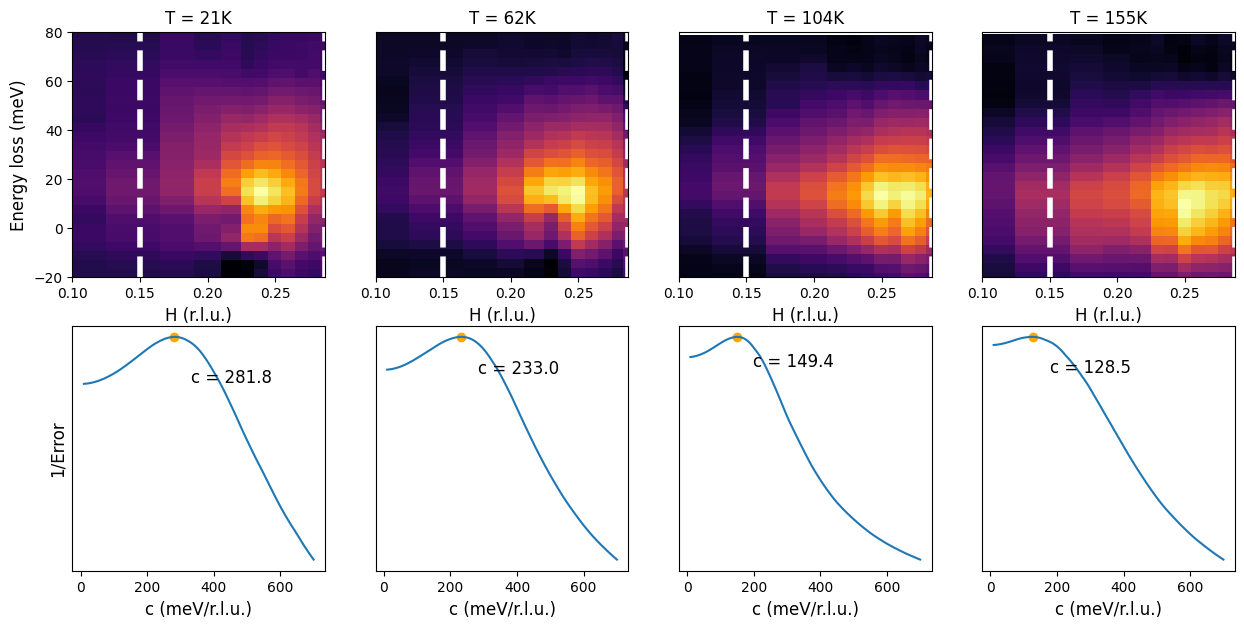

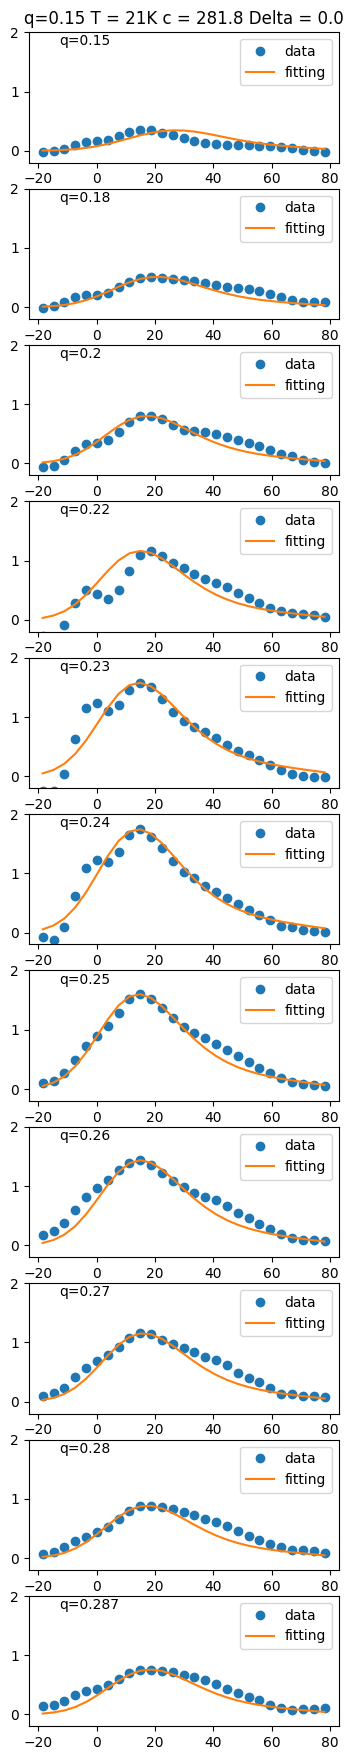

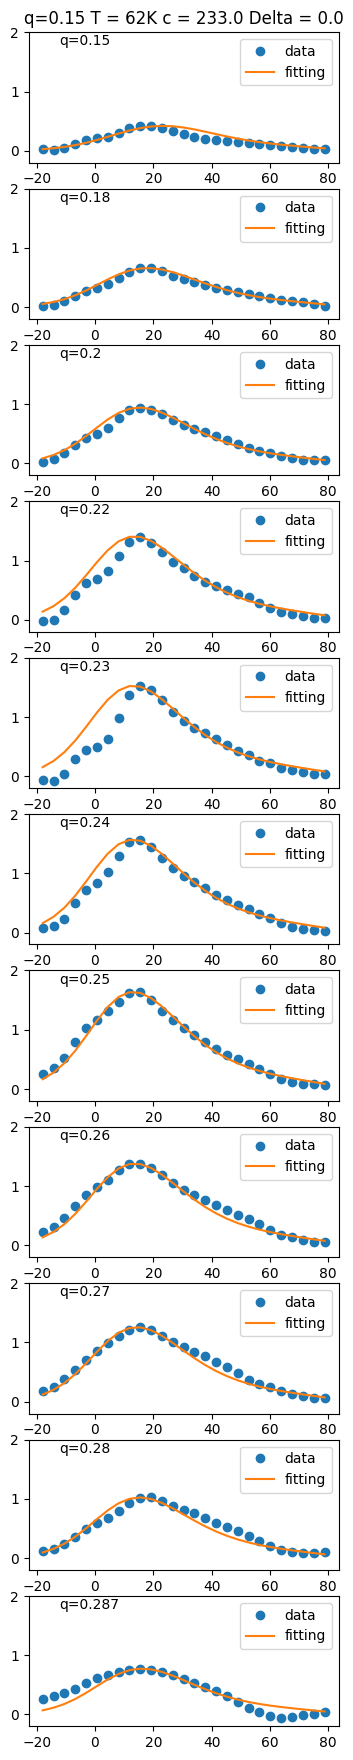

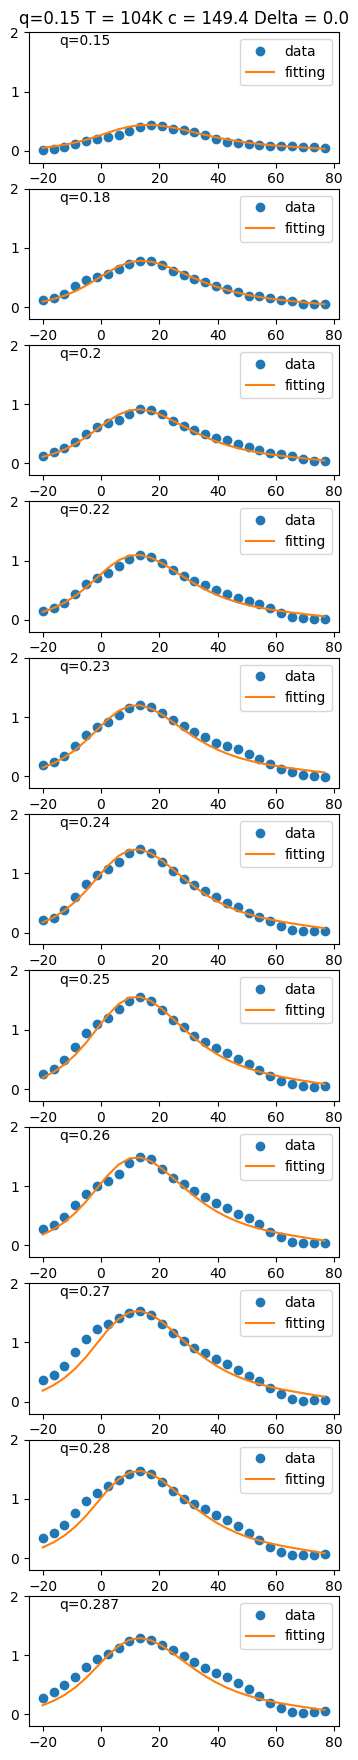

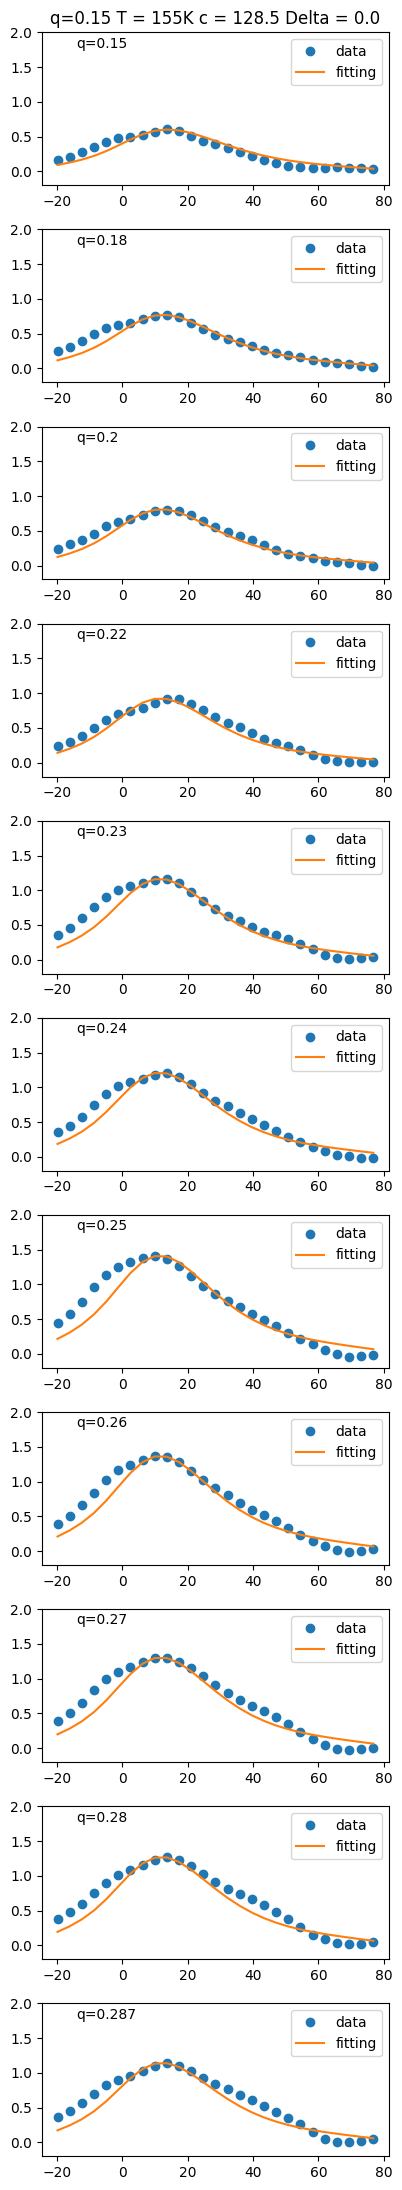

In [4]:
c_set = np.linspace(10,700,100)
Delta_set = np.linspace(0.01,0.012,2)
q_list =  exp.q_list
q_interest_list = [2,3,4,5,6,7,8,9,10,11,12]
chi_mesh = np.zeros((len(c_set),len(Delta_set)))
Gamma_set = [19,22.6,23.6,24.8]

energy_min = -20
energy_max = 80

fig4, ax4 = plt.subplots(2,4,figsize=(15,7))
c_best_list = np.zeros(4)

for temperature_index in range(4):
    Gamma = Gamma_set[temperature_index]
    temperature_char = exp._temperature_list_string[temperature_index]
    temperature = exp._temperature_list_K[temperature_index]
    temperature_meV = exp._temperature_list_meV[temperature_index]
    print(temperature_meV)
    # load data
    x= exp.Pure_CDF_data[temperature_char]['x']
    y_temp = exp.Pure_CDF_data[temperature_char]['y']
    cdf_temp = exp.Pure_CDF_data[temperature_char]['Z_subtracted']
    X,Y = np.meshgrid(x,y_temp)
    y = y_temp[(y_temp > energy_min)&(y_temp<energy_max)]
    sigma = np.ones(len(y))
    sigma[(y>10)&(y<25)]=0.3
    arg_list = np.argwhere((y_temp>energy_min)&(y_temp<energy_max))
    cdf = cdf_temp[arg_list[0][0]:arg_list[-1][0]+1,:]

    for c_index, c in enumerate(c_set):
        for Delta_index, Delta in enumerate(Delta_set):
            i_plot = 0
            sum_chi_square = 0
            for q_index, q in enumerate(q_list):
                z_data = cdf[:,q_index]
                p0 = [x[q_index],c_set[c_index],np.max(cdf[:,q_index]), Gamma, Delta_set[Delta_index], temperature_meV]
                epsilon = 0.0001
                bounds = ([x[q_index]-epsilon,c_set[c_index]-epsilon,0, Gamma-epsilon, Delta_set[Delta_index]-epsilon, temperature_meV-epsilon],\
                          [x[q_index]+epsilon,c_set[c_index]+epsilon,5, Gamma+epsilon, Delta_set[Delta_index]+epsilon, temperature_meV+epsilon])
                #popt, pcov = curve_fit(fun_S_convoluted, y, z_data, p0 = p0, bounds=bounds, sigma=sigma)
                #intensity = popt[2]
                #z_fitting = fun_S_convoluted(y,x[q_index], c_set[c_index], intensity, Gamma, Delta_set[Delta_index], temperature_meV)  
                z_fitting = mf.fun_S_convoluted_new(y,x[q_index], c_set[c_index], np.max(z_data), Gamma, Delta_set[Delta_index], temperature_meV)  
                if q_index in q_interest_list:
                    sum_chi_square = sum_chi_square + chi_square(z_data,z_fitting,sigma)
                chi_mesh[c_index,Delta_index] = np.sqrt(sum_chi_square)

    # plot the 3d surface and the pcolor plot of chi_square
    C,D = np.meshgrid(c_set,Delta_set)
    X,Y = np.meshgrid(x,y)
    ax4[0][temperature_index].pcolor(X,Y,cdf,cmap='inferno')
    ax4[0][temperature_index].set_xlim([0.1,0.287])
    ax4[0][temperature_index].set_ylim([energy_min,energy_max])
    ax4[0][temperature_index].set_xlabel('H (r.l.u.)',fontsize=12)
    ax4[0][temperature_index].set_yticks([])
    #ax4[0][temperature_index].set_ylim([3,80])
    ax4[0][temperature_index].set_title('T = '+str(exp.temperature_list_K[temperature_index])+'K')
    ax4[0][temperature_index].axvline(x=q_list[q_interest_list[0]], color='white', linewidth=4, linestyle='--')
    ax4[0][temperature_index].axvline(x=q_list[q_interest_list[-1]], color='white', linewidth=4, linestyle='--')
    reward = 1/chi_mesh.T
    ax4[1][temperature_index].plot(C[1,:],reward[1,:])
    ax4[1][temperature_index].set_xlabel('c (meV/r.l.u.)',fontsize=12)
    ax4[1][temperature_index].set_yticks([])
    if temperature_index == 0: 
        ax4[0][temperature_index].set_ylabel('Energy loss (meV)',fontsize=12)
        ax4[0][temperature_index].set_yticks([energy_min,0,20,40,60,energy_max])
        ax4[1][temperature_index].set_ylabel('1/Error',fontsize=12)

    #ax4[1][temperature_index].set_title('1/error')
    # find the highest reward, put a orange there 
    max_index = np.argwhere(reward == np.max(reward))
    ax4[1][temperature_index].scatter(C[reward==np.max(reward)],reward[reward==np.max(reward)],color='orange')
    # write the c and delta coordinate as a text on the figure. keep only 1 decimal
    ax4[1][temperature_index].text(C[reward==np.max(reward)]+50,reward[reward==np.max(reward)]*0.9,'c = '+str(round(C[reward==np.max(reward)][0],1)),fontsize=12)
    #plot colorbar
    # fig3.colorbar(ax4[1][temperature_index].pcolor(C,D,reward,cmap='jet'),ax=ax4[1][temperature_index])
    # find the best c and Delta
    c_best = C[reward==np.max(reward)][0]
    c_best_list[temperature_index] = c_best
    Delta_best = D[reward==np.max(reward)][0]
    fig, ax = plt.subplots(len(q_interest_list),1,figsize=(4,2*len(q_interest_list)))
    k=0
    
    for ii,q in enumerate(q_list):
        if ii not in q_interest_list: continue
        ax[k].plot(y,cdf[:,ii],'o',label='data')
        ax[k].plot(y,mf.fun_S_convoluted_new(y, q, c_best, np.max(cdf[:,ii]), Gamma, Delta_best, temperature_meV),label='fitting')
        if k ==0: ax[k].set_title('q='+str(q) + ' T = '+str(temperature)+'K' + ' c = '+str(round(c_best,1)) + ' Delta = '+str(round(Delta_best,1)))
        ax[k].legend()
        # add a text to show the q value
        ax[k].text(0.1,0.9,'q='+str(q),transform=ax[k].transAxes)
        ax[k].set_ylim([-0.2,2])
        k=k+1
    

# save fig4
fig.tight_layout()
fig4.savefig('figures/cdf_global_fit_for_c.jpg',dpi = 100)


In [5]:
Delta_best

0.012

1.8102
5.3444
8.9648
13.361


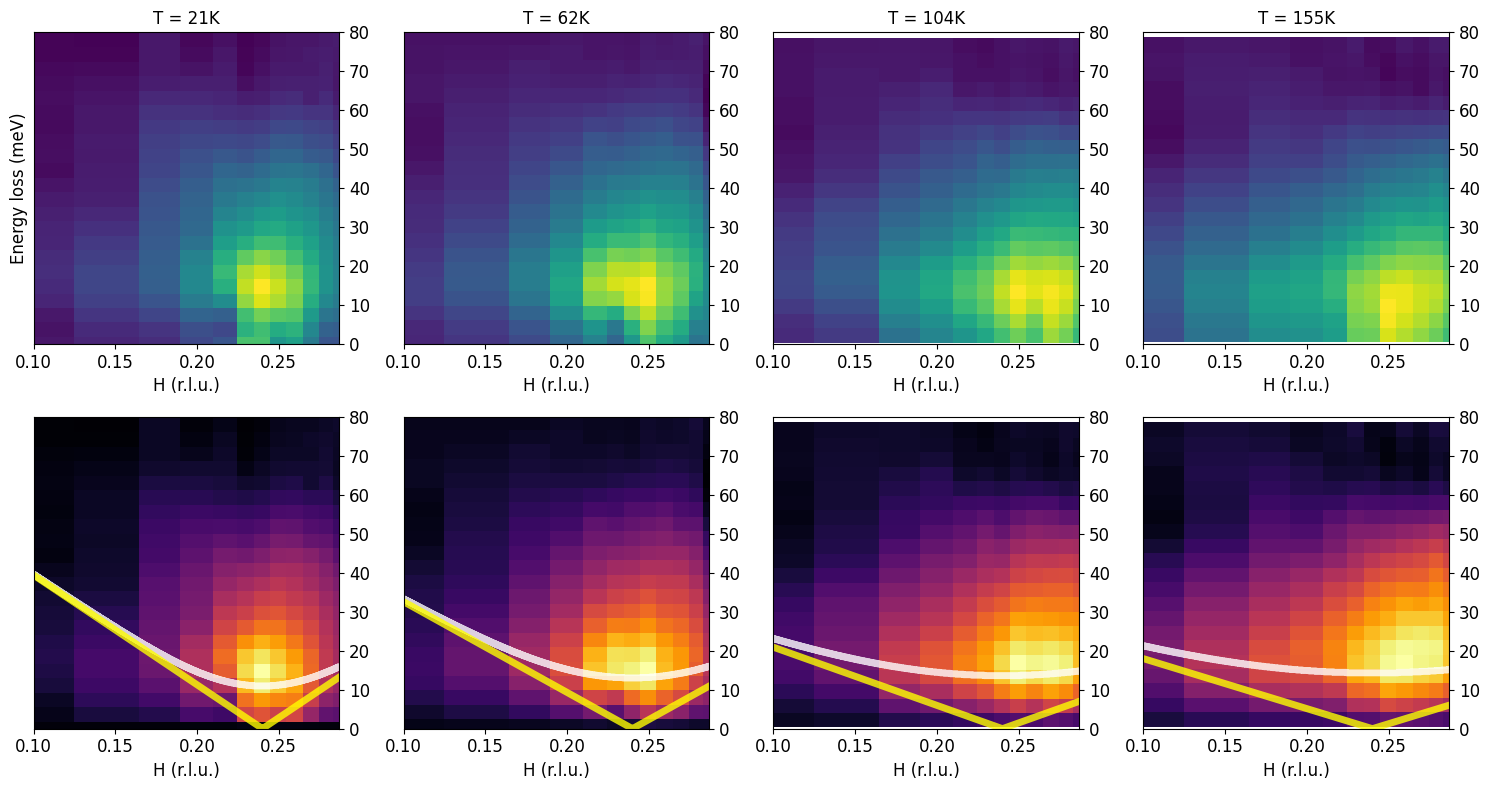

In [7]:
# divide the data with the bose factor

energy_min = 0
energy_max = 80

fig4, ax = plt.subplots(2,4,figsize=(15,8))




for temperature_index in range(4):
    Gamma = Gamma_set[temperature_index]
    temperature_char = exp._temperature_list_string[temperature_index]
    temperature = exp._temperature_list_K[temperature_index]
    temperature_meV = exp._temperature_list_meV[temperature_index]
    print(temperature_meV)
    # load data
    x= exp.Pure_CDF_data[temperature_char]['x']
    y_temp = exp.Pure_CDF_data[temperature_char]['y']
    cdf_temp = exp.Pure_CDF_data[temperature_char]['Z_subtracted']
    X,Y = np.meshgrid(x,y_temp)
    y = y_temp[(y_temp > energy_min)&(y_temp<energy_max)]
    arg_list = np.argwhere((y_temp>energy_min)&(y_temp<energy_max))
    cdf = cdf_temp[arg_list[0][0]:arg_list[-1][0]+1,:]
    # plot the 3d surface and the pcolor plot of chi_square
    C,D = np.meshgrid(c_set,Delta_set)
    X,Y = np.meshgrid(x,y)
    ax[0][temperature_index].pcolor(X,Y,cdf)
    ax[0][temperature_index].set_xlim([0.1,0.287])
    ax[0][temperature_index].set_ylim([energy_min,energy_max])
    ax[0][temperature_index].set_xlabel('H (r.l.u.)',fontsize=12)
    # set y ticks to the right
    ax[0][temperature_index].yaxis.tick_right()
    #ax[0][temperature_index].set_ylim([3,80])
    ax[0][temperature_index].set_title('T = '+str(exp.temperature_list_K[temperature_index])+'K')
    if temperature_index == 0: 
        ax[0][temperature_index].set_ylabel('Energy loss (meV)',fontsize=12)

    ax[1][temperature_index].pcolor(X,Y,cdf/bose_factor(Y,temperature_meV),cmap='inferno')
    ax[1][temperature_index].set_xlim([0.1,0.287])
    ax[1][temperature_index].set_ylim([energy_min,energy_max])
    ax[1][temperature_index].set_xlabel('H (r.l.u.)',fontsize=12)
    # ticks size to 12
    ax[1][temperature_index].tick_params(axis='both', which='major', labelsize=12)
    ax[0][temperature_index].tick_params(axis='both', which='major', labelsize=12)
    # set y ticks to the right
    ax[1][temperature_index].yaxis.tick_right()
    #ax[1][temperature_index].set_ylim([3,80])
    if temperature_index == 0: 
        ax[0][temperature_index].set_ylabel('Energy loss (meV)')
    x,p = peaks_of_chi(c_best_list[temperature_index],Gamma,Delta_best)

    ax[1][temperature_index].plot(x,p,color='white',linewidth=5,alpha=0.8)
    ax[1][temperature_index].plot(x,np.sqrt(Delta_best**2 + c_best_list[temperature_index]**2*(x-0.24)**2),color='yellow',linewidth=5,alpha=0.8)

fig4.tight_layout()
fig4.savefig('figures/cdf_dispersion_bose_factor.jpg',dpi = 100)